![Insper](https://github.com/danielscarvalho/Insper-DS-Dicas/blob/master/Insper-Logo.png?raw=true)

# Insper Pós-Graduação
## Programa Avançado em Data Science e Decisão [»](https://www.insper.edu.br/pos-graduacao/programas-avancados/programa-avancado-em-data-science-e-decisao/)


# Atividade Integradora
## Setup

### Dependencias

In [1]:
import pandas as pd
import numpy as np
from dfply import *
import altair as alt
import missingno as msno
from ydata_profiling import ProfileReport
import matplotlib
import matplotlib.pyplot as plt 

### Carregamento dos Dados

In [2]:
data = pd.read_csv("cs_bisnode_panel.csv")
dicionario_de_dados_0 = pd.read_excel("bisnode_variable_names.xls", header=4)

In [3]:
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


## Limpeza dos Dados

### Dicionário de dados - Limpeza

Ao carregar o dicionário de dados a primeira coluna pega seu nome da quarta linha da tabela (argumento `header=4` acima). As outras três colunas são nomeadas abaixo.

In [4]:
dicionario_de_dados_1 = dicionario_de_dados_0.rename({'Unnamed: 1': 'description',
                                                      'Unnamed: 2': 'type',
                                                      'Unnamed: 3': 'footnote'},
                                                     axis=1)

In [5]:
dicionario_de_dados_1.columns

Index(['variable', 'description', 'type', 'footnote'], dtype='object')

Então retiramos as linhas não relevantes para a analize, incluindo linhas totalmente em branco e uma linha com informação de versão da base de dados: 
 - `v 0.92. 2021-02-04`

In [6]:
dicionario_de_dados = dicionario_de_dados_1\
                       .drop(index=54)\
                       .dropna(how="all")\
                       .reset_index()\
                       .drop('index', axis='columns')

In [7]:
dicionario_de_dados.sample(5)

,variable,description,type,footnote
33,foreign,Share of foreign CEOs,numeric,percent
14,inventories,inventories,numeric,(euros)
31,exit_year,Firm exit year,date,NaN
36,inoffice_days,Avg time CEOS are in office,numeric,NaN
25,wages,Wages (wage bill),numeric,(euros)


## Dados
### Removendo colunas específicas:

In [8]:
columns_to_remove = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D']

data.drop(columns=columns_to_remove, inplace=True)

data.columns

Index(['comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets',
       'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets',
       'material_exp', 'personnel_exp', 'profit_loss_year', 'sales',
       'share_eq', 'subscribed_cap', 'tang_assets', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'year', 'founded_year',
       'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year',
       'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'ind',
       'urban_m', 'region_m', 'founded_date', 'exit_date', 'labor_avg'],
      dtype='object')

### Removendo dados do ano 2016:
---

Registros que começaram ou terminaram (ocorreram em) 2016 são removidos do conjunto.

In [9]:
data = data[data["year"]!=2016]
data["year"].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015],
      dtype=int64)

### Missing data:
---

Vamos verificar dados faltando do banco de dados:

In [10]:
colunas_data = ["begin", "end", "founded_date", "exit_date"]

data.dtypes[colunas_data]

begin           object
end             object
founded_date    object
exit_date       object
dtype: object

In [11]:
for column in colunas_data:
    data[column] = pd.to_datetime(data[column], format="%Y-%m-%d")

data[colunas_data].dtypes

begin           datetime64[ns]
end             datetime64[ns]
founded_date    datetime64[ns]
exit_date       datetime64[ns]
dtype: object

In [12]:
def show_missing(df):
    """Return a Pandas dataframe describing the contents of a source dataframe including missing values."""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        'pc_missing': pc_missing
    })    
        
    return output

Verificando dados com maior falta de informações:

In [13]:
missing_data = show_missing(data).sort_values("pc_missing", ascending=False, ignore_index = True)

index_full_data = list(missing_data[missing_data["missing"]==0].index)

missing_data.drop(labels=index_full_data, axis="index", inplace=True)

missing_data

,variable,dtype,count,unique,missing,pc_missing
0,exit_year,float64,278086,19,239228,86.03
1,exit_date,datetime64[ns],278086,2603,221908,79.80
2,labor_avg,float64,278086,5556,146483,52.68
3,birth_year,float64,278086,264,110557,39.76
4,founded_year,float64,278086,39,56178,20.20
5,gender,object,278086,4,56148,20.19
6,origin,object,278086,4,56148,20.19
7,female,float64,278086,15,56148,20.19
8,foreign,float64,278086,16,56148,20.19
9,ceo_count,float64,278086,15,56148,20.19


Vamos iniciar tratando os dados que estejam com menos de 5% de dados faltando.

Podemos considerar que pela quantidade de dados estes casos são insignificantes no escopo total então vamos apenas remover estes.

(apenas para as colunas com baixa falta de dados ">5%")

In [14]:
removable_na_columns = list(missing_data["variable"][missing_data["pc_missing"]<5.0])

data.dropna(subset=removable_na_columns, ignore_index=True, inplace=True)

In [15]:
missing_val_columns = missing_data["variable"][missing_data["pc_missing"]>0]

<Axes: >

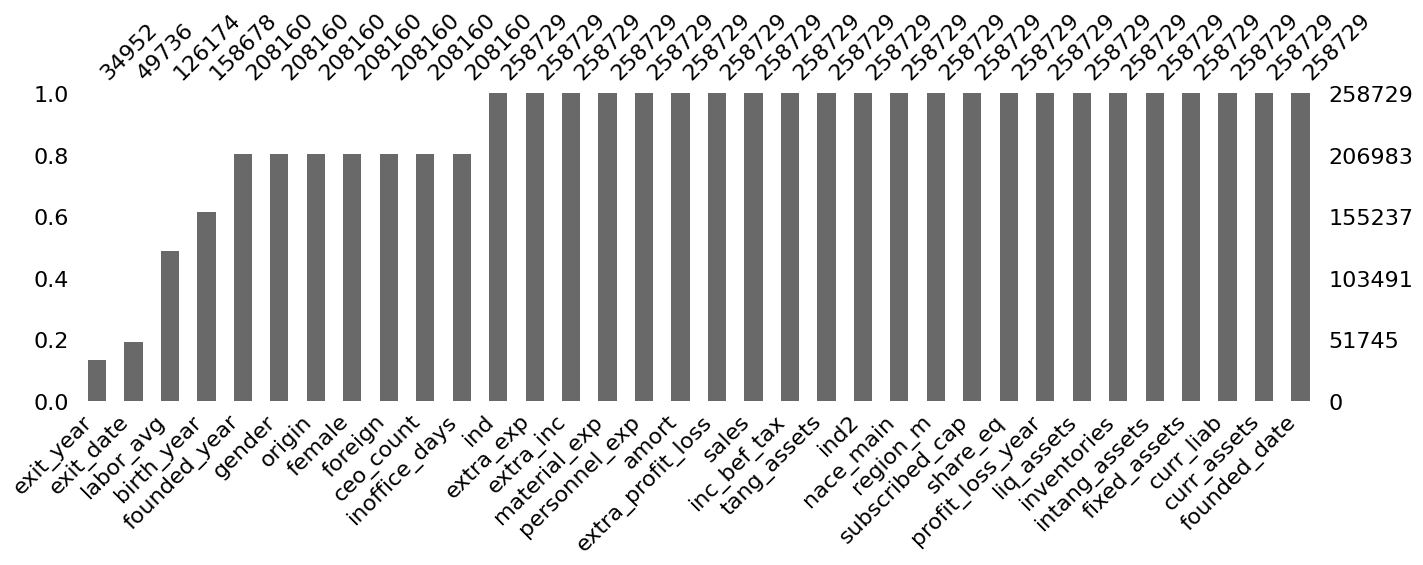

In [16]:
msno.bar(data[missing_val_columns], figsize=(16, 4))

Dados destas colunas precisam estar em formato de datetime para serem operados corretamente, então vamos converte-los.

In [17]:
missing_data_2 = show_missing(data).sort_values("pc_missing", ascending=False, ignore_index = True)

index_full_data_2 = list(missing_data_2[missing_data_2["missing"]==0].index)

missing_data_2.drop(labels=index_full_data_2, axis="index", inplace=True)

missing_data_2

,variable,dtype,count,unique,missing,pc_missing
0,exit_year,float64,258729,19,223777,86.49
1,exit_date,datetime64[ns],258729,2473,208993,80.78
2,labor_avg,float64,258729,5385,132555,51.23
3,birth_year,float64,258729,261,100051,38.67
4,inoffice_days,float64,258729,10876,50569,19.55
5,founded_year,float64,258729,39,50569,19.55
6,ceo_count,float64,258729,15,50569,19.55
7,foreign,float64,258729,16,50569,19.55
8,female,float64,258729,15,50569,19.55
9,gender,object,258729,4,50569,19.55


Removendo Registros do ano de 2016:

In [18]:
Agora vamos tratar os dados que estão com faltas consideráveis e se faz sentido a falta de dados.

SyntaxError: invalid syntax (1677005153.py, line 1)

### Criando coluna para Variável Dependente:
---

- Vamos operar com o conceito de "atividade", empresas que não tiveram atividade por mais de 2 anos são consideradas "inativas".

Obs.: ativa = 0, inativa = 1

In [ ]:
# Sort the DataFrame by company and year
data.sort_values(by=['comp_id', 'year'], inplace=True)

# Create shifted columns to check sales in the following 2 years
conditions_x1 = [((data['comp_id'] == data['comp_id'].shift(-1)) &
                  (data['year'] == data['year'].shift(-1) - 1)),

                 ((data['comp_id'] != data['comp_id'].shift(-1)) |
                  data['year'] != data['year'].shift(-1))]

values_x1 = [data['sales'].shift(-1),
             np.nan]

data['sales_x1'] = np.select(conditions_x1, values_x1)


conditions_x2 = [
    ((data['comp_id'] == data['comp_id'].shift(-1)) &
     (data['year'] == data['year'].shift(-1) - 2)),

    ((data['comp_id'] == data['comp_id'].shift(-2)) &
     (data['year'] == data['year'].shift(-2) - 2)),

    True
]

values_x2 = [data['sales'].shift(-1),
             data['sales'].shift(-2),
             np.nan]

data['sales_x2'] = np.select(conditions_x2, values_x2)


# Create a condition to identify companies that ceased to operate 
# (sem vendas por mais de 2 anos)
condition = (data['sales_x1'] == 0) & (data['sales_x2'] == 0)

# Create a new 'dependente' column with 1 for ceased companies and 0 otherwise
data['dependente'] = condition.astype(int)


Vamos conferir os valores da variavel dependente para as duas primeiras empresas do dataframe:

In [ ]:
# lista de colunas para avaliação:
check_list=["comp_id", "year", "sales", "sales_x1", "sales_x2", "dependente"]

data[check_list].head(18)

In [ ]:
data[check_list].describe()

,comp_id,year,sales,sales_x1,sales_x2,dependente
count,2.587290e+05,258729.000000,2.587290e+05,2.587280e+05,2.587270e+05,258729.000000
mean,1.540156e+11,2010.448319,4.731183e+05,4.731199e+05,4.731215e+05,0.091714
std,1.382643e+11,3.066244,3.775571e+06,3.775578e+06,3.775585e+06,0.288622
min,1.001034e+06,2005.000000,-1.472559e+07,-1.472559e+07,-1.472559e+07,0.000000
25%,2.857290e+10,2008.000000,4.744444e+03,4.744444e+03,4.744444e+03,0.000000
50%,1.153078e+11,2011.000000,3.042222e+04,3.042222e+04,3.042222e+04,0.000000
75%,2.593265e+11,2013.000000,1.106704e+05,1.106704e+05,1.106704e+05,0.000000
max,4.641209e+11,2015.000000,1.110294e+08,1.110294e+08,1.110294e+08,1.000000


Vemos que temos dados de venda com erros, onde há valores negativos para vendas, vamos tratar estes dados substituindo valores negativos por nulos (valor = 0)

In [ ]:
# Remodelando os dados de vendas para corrigir os erros:

for x in ["sales", "sales_x1", "sales_x2"]:
    data[x] = np.where(data[x]<0, 0, data[x])

data['dependente'] = condition.astype(int)

In [ ]:
data[check_list].describe()

,comp_id,year,sales,sales_x1,sales_x2,dependente
count,2.587290e+05,258729.000000,2.587290e+05,2.587280e+05,2.587270e+05,258729.000000
mean,1.540156e+11,2010.448319,4.731984e+05,4.731999e+05,4.732015e+05,0.091714
std,1.382643e+11,3.066244,3.775438e+06,3.775446e+06,3.775453e+06,0.288622
min,1.001034e+06,2005.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.857290e+10,2008.000000,4.744444e+03,4.744444e+03,4.744444e+03,0.000000
50%,1.153078e+11,2011.000000,3.042222e+04,3.042222e+04,3.042222e+04,0.000000
75%,2.593265e+11,2013.000000,1.106704e+05,1.106704e+05,1.106704e+05,0.000000
max,4.641209e+11,2015.000000,1.110294e+08,1.110294e+08,1.110294e+08,1.000000


Corrigimos os valores de vendas negativas, e assim também de dependentes que pudessem estar sendo afetados.

Vamos agora:
 
- tratar por fim os casos em que não há informações de venda para um próximo ano (por não haver um próximo ano;

- criar uma coluna de vendas em "Log" para tratar a assimetria dos dados.

Vamos averiguar agora os anos em que as empresas tiveram atividade e inatividade:

In [ ]:
data_grouped = data.groupby('comp_id')

#Contando anos de acompanhamento
comp_years = data_grouped['year'].count()

#Contando anos de "atividade"
active_years = data_grouped.apply(lambda group: (group['sales'] > 0).sum())

#contando anos de "inatividade"
inactive_years = data_grouped.apply(lambda group: (group['sales'] == 0).sum())

#Contando anos de "dependência"
depend_years = data_grouped.apply(lambda group: (group['dependente'] == 1).sum())

In [ ]:
activity_df = pd.DataFrame({"Total years":comp_years,
                            "Active years":active_years, 
                            "Inactive years":inactive_years,
                            "Dependent years":depend_years})

activity_df

## 2012

In [ ]:
data_2012 = data[data['year'] == 2012]
data_2012.year.unique()

array([2012], dtype=int64)

In [ ]:
import math

### Sales

In [ ]:
data_2012.sales.describe()

Valores negativos não são válidos para a váriavel `sales`. O tratamento escolhido nesse caso é substituir valores negativos por 0.

In [ ]:
data_2012.loc[data['sales'] < 0] = 0
data_2012.sales.describe()

Podemos ver ainda nas estatísticas descritivas que a média é maior que o terceiro quartil, indicando uma distribuição bastante assimétrica. Criamos então uma com o logarítmo de `sales` para auxiliar na análise.

In [ ]:
data_2012.loc[:,'log_sales'] = data_2012.sales\
                                        .apply(lambda x: math.log(x)\
                                               if x != 0\
                                               else 0)

data_2012.log_sales.describe()

### Idade da Empresa
A idade da empresa eh calculada pela subtracao de `year` por `founded_year`, e a informacao eh guardada em `comp_age`.

In [ ]:
data.year.isna().sum()

In [ ]:
data.founded_year.isna().sum()

In [ ]:
duplicates = {'company': [], 'years': []}
nulls = {'company': [], 'years': []}

for company in data_2012.comp_id.unique():
    company_year = data_2012.loc[data_2012['comp_id'] == company,
                                 'founded_year'].unique()
    if len(company_year) != 1:
        duplicates['company'].append(company)
        duplicates['years'].append(company_year)
    elif np.nan in company_year:
        nulls['company'].append(company)
        nulls['years'].append(company_year)

nulls

In [ ]:
data_2012.loc[data_2012['comp_id'] == 1001034,
              'founded_year'].unique()

In [ ]:
data_2012.loc[(data_2012['comp_id'] == 1001034) &
              (data_2012['founded_year'] == np.nan)]

In [ ]:
data_2012.to_csv("data_2012")